In [82]:
import json
import math
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn import metrics
#from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix # To build sparse feature matrices, if you like
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
dataset = json.load(open("train-transcripts-aligned.json", 'r+'))

In [109]:
datasetTest = json.load(open("test-transcripts-aligned.json", 'r+'))

In [121]:
test_durations = []
test_utterance_lengths = []
test_offset = []
test_has_q = []
test_has_questions = []  # List to store 'has_q' feature
test_num_words = []
test_num_sentences = []
test_speaker_one_hot = []
for episode_id, turns in datasetTest.items():
    for turn in turns:
        duration = turn['utterance_end'] - turn['utterance_start']
        utterance_length = len(turn['utterance'])
        has_question = int(turn['has_q'])
        words = turn['n_words']
        sentences = turn['n_sentences']
        
        if turn['speaker'] in top100.keys():
            oneHot = top100[turn['speaker']]
        else:
            oneHot = top100['other']
        
        test_offset.append(1)
        
        test_durations.append(duration)
        test_utterance_lengths.append(utterance_length)
        test_has_questions.append(has_question)
        test_num_words.append(words)
        test_num_sentences.append(sentences)
        test_speaker_one_hot.append(oneHot)
        
y_test = np.array(test_durations)

In [4]:
print(dataset['ep-1'][0]['duration'])
print(dataset['ep-1'][0])

0.4099999999999999
{'episode': 'ep-1', 'act': 'prologue', 'act_title': 'Prologue', 'role': 'interviewer', 'speaker': 'ira glass', 'utterance_start': 0.17, 'utterance_end': 0.58, 'duration': 0.4099999999999999, 'utterance': 'Joe Franklin?', 'n_sentences': 1, 'n_words': 3, 'has_q': True, 'ends_q': True, 'alignments': [[0.17, 0.45000000000000007, 0], [0.45000000000000007, 0.5700000000000001, 1]]}


In [5]:
actNames = defaultdict(int)
actTitles = defaultdict(int)
roles = defaultdict(int)
speakersUtterances = defaultdict(int)
episodeEntries = defaultdict(int)
totalUtterances = 0
for x in dataset:
    for y in dataset[x]:
        actNames[y['act']] += 1
        actTitles[y['act_title']] += 1
        roles[y['role']] += 1
        speakersUtterances[y['speaker']] += 1
        episodeEntries[y['episode']] += 1       
        totalUtterances += 1

In [6]:
print(totalUtterances)

145818


Text(0.5, 1.0, 'Bar Graph with Randomized Colors')

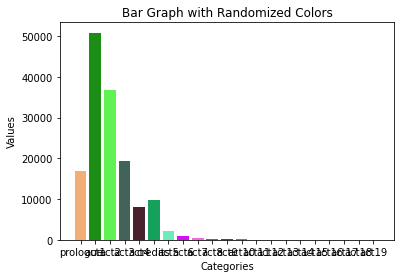

In [7]:
categories = list(actNames.keys())
values = [entry for entry in actNames.values()]
colors = [('#%06x' % random.randint(0, 0xFFFFFF)) for _ in range(len(categories))]

# Create a bar graph
plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph with Randomized Colors')

Text(0.5, 1.0, 'Bar Graph with Randomized Colors')

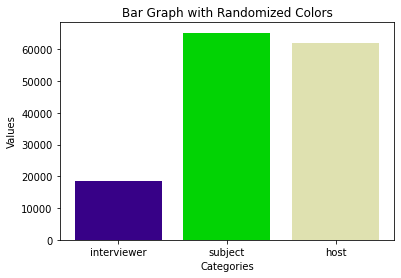

In [8]:
categories = list(roles.keys())
values = [entry for entry in roles.values()]
colors = [('#%06x' % random.randint(0, 0xFFFFFF)) for _ in range(len(categories))]

# Create a bar graph
plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph with Randomized Colors')

In [9]:
interviewer_length = []
host_length = []
subject_length = []
total_length = []
data = dataset['ep-1']

for x in dataset:
    for y in dataset[x]:
        if y['role'] == 'interviewer':
            interviewer_length.append(y['duration'])
        elif y['role'] == 'host':
            host_length.append(y['duration'])
        else:
            subject_length.append(y['duration'])
        total_length.append(y['duration'])

In [10]:
i_length = sum(interviewer_length)
h_length = sum(host_length)
s_length = sum(subject_length)
t_length = sum(total_length)
print(i_length, h_length, s_length, t_length)
print("percent of interviewar utterances: ", i_length/t_length)
print("percent of host utterances: ", h_length/t_length)
print("percent of subject utterances: ", s_length/t_length)

i_average = i_length/len(interviewer_length)
h_average = h_length/len(host_length)
s_average = s_length/len(subject_length)
t_average = t_length/len(total_length)
print('average length of utterances interviewer, host, subject, total: ', i_average, h_average, s_average, t_average)

92845.56506122439 1152119.3599224729 807833.3609384841 2052798.2859221532
percent of interviewar utterances:  0.045228781462819924
percent of host utterances:  0.5612433368751185
percent of subject utterances:  0.3935278816620753
average length of utterances interviewer, host, subject, total:  4.979382444557781 18.591866254457436 12.389512153405274 14.077811284766991


Text(0.5, 1.0, 'Bar Graph with Randomized Colors')

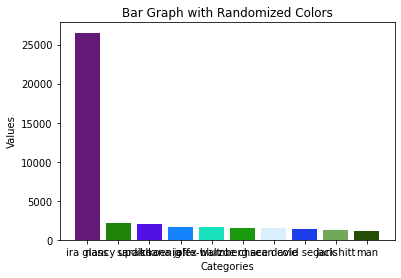

In [11]:
sorted_data = dict(sorted(speakersUtterances.items(), key=lambda x: x[1], reverse=True)[:10])

categories = list(sorted_data.keys())
values = list(sorted_data.values())
colors = [('#%06x' % random.randint(0, 0xFFFFFF)) for _ in range(len(categories))]

# Create a bar graph
plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph with Randomized Colors')

In [12]:
sorted_dataSpeaker = dict(sorted(speakersUtterances.items(), key=lambda x: x[1], reverse=True)[:100])
for key, value in list(sorted_dataSpeaker.items())[:100]:
    print(f'{key}: {value}')

ira glass: 26523
nancy updike: 2100
sarah koenig: 2071
chana joffe-walt: 1696
alex blumberg: 1626
zoe chace: 1528
sean cole: 1457
david sedaris: 1349
jack hitt: 1217
man: 1136
david kestenbaum: 1078
jonathan goldstein: 1036
ben calhoun: 1009
sarah vowell: 871
adam davidson: 846
miki meek: 821
woman: 786
alix spiegel: 767
scott carrier: 700
david rakoff: 653
stephanie foo: 636
neil drumming: 603
lisa pollak: 534
elna baker: 528
interpreter: 525
starlee kine: 522
dana chivvis: 495
jon ronson: 481
michael lewis: 450
brian reed: 438
alex kotlowitz: 426
robyn semien: 419
announcer: 418
matt malloy: 403
susan burton: 347
dan savage: 342
paul tough: 340
hyder akbar: 339
emanuele berry: 339
julie snyder: 324
james spring: 323
sandra tsing loh: 316
shalom auslander: 312
davy rothbart: 306
lilly sullivan: 291
russell banks: 285
translator: 277
abdi nor: 271
jane feltes: 259
john hodgman: 254
margy rochlin: 248
mike birbiglia: 244
man 1: 242
woman 1: 242
kirk johnson: 242
brett martin: 241
julia 

In [13]:
speakerTime = defaultdict(int)

for x in dataset:
    for y in dataset[x]:
        speakerTime[y['speaker']] += y['duration']

Text(0.5, 1.0, 'Bar Graph with Randomized Colors')

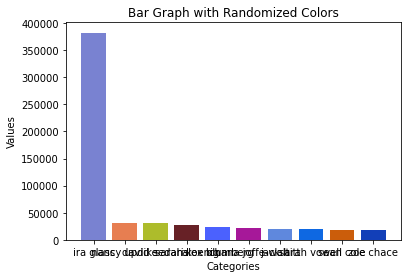

In [14]:
sorted_data = dict(sorted(speakerTime.items(), key=lambda x: x[1], reverse=True)[:10])

categories = list(sorted_data.keys())
values = list(sorted_data.values())
colors = [('#%06x' % random.randint(0, 0xFFFFFF)) for _ in range(len(categories))]

# Create a bar graph
plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph with Randomized Colors')

In [15]:
sorted_dataSpeaker = dict(sorted(speakerTime.items(), key=lambda x: x[1], reverse=True)[:100])
for key, value in list(sorted_dataSpeaker.items())[:100]:
    print(f'{key}: {value}')

ira glass: 382211.3379214892
nancy updike: 31079.829999999973
david sedaris: 30274.26000000002
sarah koenig: 26803.68999999999
alex blumberg: 22776.31000000003
chana joffe-walt: 21862.27401360544
jack hitt: 19908.150000000045
sarah vowell: 19373.829999999958
sean cole: 18116.549359835608
zoe chace: 17910.60999999997
scott carrier: 15821.390000000007
jonathan goldstein: 15594.839999999998
david rakoff: 15298.509999999995
ben calhoun: 14861.01999999999
alix spiegel: 13548.540000000005
david kestenbaum: 12451.254000000019
adam davidson: 12411.220000000005
matt malloy: 9338.949999999999
stephanie foo: 8751.410000000007
miki meek: 8562.150000000007
michael lewis: 8525.379999999997
man: 8142.685759637208
neil drumming: 7710.322499999997
elna baker: 7709.879999999998
jon ronson: 7674.480000000014
dan savage: 7496.550000000001
woman: 7176.819999999998
sandra tsing loh: 7090.909999999998
starlee kine: 6598.929999999996
hyder akbar: 6593.369999999997
alex kotlowitz: 6466.219999999996
julia sween

In [16]:
question_length = []
total_length = []
statement_length = []
data = dataset['ep-1']

for d in data:
    if d['has_q'] is True:
        question_length.append(d['duration'])
    else:
        statement_length.append(d['duration'])
    total_length.append(d['duration'])

In [17]:
# question utterance duration is about 0.775 times shorter than statement utterance duration
q_length = sum(question_length)
t_length = sum(total_length)
s_length = sum(statement_length)
print(q_length, s_length, t_length)
print(s_length/q_length)
print(t_length/q_length)

q_average = q_length/len(question_length)
s_average = s_length/len(statement_length)
t_average = t_length/len(total_length)
print('average q,s,t: ', q_average, s_average, t_average)
print(q_average/s_average)

801.5500000000005 2723.4133333333316 3524.9633333333322
3.397683654585902
4.397683654585903
average q,s,t:  15.414423076923088 19.878929440389282 18.650599647266308
0.7754151511602343


## Learning Utterance Duration

In [18]:
def MSE(ypred,y):
    diffs = [(a-b)**2 for (a,b) in zip(y,ypred)]
    return sum(diffs) / len(diffs)

In [19]:
def MAE(ypred,y):
    diffs = [abs(a-b) for (a,b) in zip(y,ypred)]
    return sum(diffs)/len(diffs)

In [111]:
offset = []
utterance_lengths = []
durations = []

# Iterating through each episode
for episode_id, turns in dataset.items():
    # Iterating through each turn in the episode
    for turn in turns:
        utterance_length = len(turn['utterance'])
        duration = turn['utterance_end'] - turn['utterance_start']

        offset.append(1)
        utterance_lengths.append(utterance_length)
        durations.append(duration)
        
X_train = np.array(utterance_lengths).reshape(-1, 1)  # Features (utterance lengths)
y_train = np.array(durations)  # Target (durations)

print("X sample:", X[:5])  # Print first 5 samples of features
print("y sample:", y[:5])  # Print first 5 samples of targets

X sample: [[13]
 [10]
 [20]
 [38]
 [32]]
y sample: [0.41 0.81 1.45 1.61 1.44]


In [119]:
# Split the data into training and testing sets
X_test = np.array(test_utterance_lengths).reshape(-1, 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Test the model (optional)
y_pred = model.predict(X_test)
lengthOnly = MAE(y_pred,y_test)

In [120]:
print("MAE with only length of utterance as a feature: ", lengthOnly)

MAE with only length of utterance as a feature:  2.914514204817403


In [122]:
offset = []
utterance_lengths = []
durations = []
has_questions = []  # List to store 'has_q' feature

# Iterating through each episode
for episode_id, turns in dataset.items():
    # Iterating through each turn in the episode
    for turn in turns:
        utterance_length = len(turn['utterance'])
        duration = turn['utterance_end'] - turn['utterance_start']
        has_question = int(turn['has_q'])  # Convert boolean to int (True to 1, False to 0)

        offset.append(1)
        utterance_lengths.append(utterance_length)
        durations.append(duration)
        has_questions.append(has_question)
        
X2_train = np.column_stack((offset, utterance_lengths, has_questions))  # Combine utterance lengths and has_q features
y2_train = np.array(durations)  # Target (durations)

In [123]:
# Split the data into training and testing sets
X2_test = np.column_stack((test_offset, test_utterance_lengths, test_has_questions))
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X2_train, y2_train)

# Test the model (optional)
y2_pred = model.predict(X2_test)
lengthAndQuestion = MAE(y2_pred,y_test)

In [124]:
print("MAE including the feature of if the utterance has a question: ", lengthAndQuestion)

MAE including the feature of if the utterance has a question:  2.9144093229797425


In [127]:
offset = []
utterance_lengths = []
durations = []
has_questions = []  # List to store 'has_q' feature
num_words = []

# Iterating through each episode
for episode_id, turns in dataset.items():
    # Iterating through each turn in the episode
    for turn in turns:
        utterance_length = len(turn['utterance'])
        duration = turn['duration']
        has_question = int(turn['has_q'])  # Convert boolean to int (True to 1, False to 0)
        words = turn['n_words']

        offset.append(1)
        utterance_lengths.append(utterance_length)
        durations.append(duration)
        has_questions.append(has_question)
        num_words.append(words)
        
X3_train = np.column_stack((offset, utterance_lengths, has_questions, num_words))  # Combine utterance lengths and has_q features
y3_train = np.array(durations)  # Target (durations)

In [128]:
X3_test = np.column_stack((test_offset, test_utterance_lengths, test_has_questions, test_num_words))

# Create and train the model
model = LinearRegression()
model.fit(X3_train, y3_train)

# Test the model (optional)
y3_pred = model.predict(X3_test)
addedNumWords = MAE(y3_pred,y_test)

In [129]:
print("MAE including number of words per utterance: ", addedNumWords)

MAE including number of words per utterance:  2.8050043091333037


In [130]:
offset = []
utterance_lengths = []
durations = []
has_questions = []  # List to store 'has_q' feature
num_words = []
num_sentences = []

# Iterating through each episode
for episode_id, turns in dataset.items():
    # Iterating through each turn in the episode
    for turn in turns:
        utterance_length = len(turn['utterance'])
        duration = turn['duration']
        has_question = int(turn['has_q'])  # Convert boolean to int (True to 1, False to 0)
        words = turn['n_words']
        sentence = turn['n_sentences']
        
        offset.append(1)
        utterance_lengths.append(utterance_length)
        durations.append(duration)
        has_questions.append(has_question)
        num_words.append(words)
        num_sentences.append(sentence)
        
X4_train = np.column_stack((offset, utterance_lengths, has_questions, num_words, num_sentences))  # Combine utterance lengths and has_q features
y4_train = np.array(durations)  # Target (durations)

In [131]:
X4_test = np.column_stack((test_offset, test_utterance_lengths, test_has_questions, test_num_words, test_num_sentences))

# Create and train the model
model = LinearRegression()
model.fit(X4_train, y4_train)

# Test the model (optional)
y4_pred = model.predict(X4_test)
addedNumSentence = MAE(y4_pred,y_test)

In [132]:
print("MAE including sentences per utterance: ", addedNumSentence)

MAE including sentences per utterance:  2.7925047840253843


In [133]:
def one_hot_encode_speakers(speaker_names, include_other=True):
    num_speakers = len(speaker_names)
    one_hot_dict = {}

    for i, speaker in enumerate(speaker_names):
        encoding = [0] * i + [1] + [0] * (num_speakers - i - 1)
        if include_other:
            encoding.append(0)  # Add a 0 for 'other'
        one_hot_dict[speaker] = encoding
    
    if include_other:
        # Add a separate entry for 'other' with its own one-hot encoding
        other_encoding = [0] * num_speakers + [1]
        one_hot_dict['other'] = other_encoding

    return one_hot_dict

In [134]:
top100 = one_hot_encode_speakers(sorted_dataSpeaker)

In [135]:
offset = []
utterance_lengths = []
durations = []
has_questions = []  # List to store 'has_q' feature
num_words = []
num_sentences = []
speaker_one_hot = []

# Iterating through each episode
for episode_id, turns in dataset.items():
    # Iterating through each turn in the episode
    for turn in turns:
        utterance_length = len(turn['utterance'])
        duration = turn['duration']
        has_question = int(turn['has_q'])  # Convert boolean to int (True to 1, False to 0)
        words = turn['n_words']
        sentence = turn['n_sentences']
        if turn['speaker'] in top100.keys():
            oneHot = top100[turn['speaker']]
        else:
            oneHot = top100['other']
        
        offset.append(1)
        utterance_lengths.append(utterance_length)
        durations.append(duration)
        has_questions.append(has_question)
        num_words.append(words)
        num_sentences.append(sentence)
        speaker_one_hot.append(oneHot)
        
X5_train = np.column_stack((offset, utterance_lengths, has_questions,num_words,num_sentences,speaker_one_hot))  # Combine utterance lengths and has_q features
y5_train = np.array(durations)  # Target (durations)

In [136]:
X5_train[0]

array([ 1, 13,  1,  3,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [139]:
X5_test = np.column_stack((test_offset, test_utterance_lengths, test_has_questions, test_num_words, test_num_sentences, test_speaker_one_hot))

# Create and train the model
model = LinearRegression()
model.fit(X5_train, y5_train)

# Test the model (optional)
y5_pred = model.predict(X5_test)
addedSpeaker100 = MAE(y5_pred,y_test)

In [140]:
print("MAE including a one hot for the top 100 speakers: ", addedSpeaker100)

MAE including a one hot for the top 100 speakers:  2.6773547918808545


In [141]:
def featureCreate(length, hasq, words, sentence, speaker, dataset):
    offset = []
    utterance_lengths = []
    durations = []
    has_questions = []  # List to store 'has_q' feature
    num_words = []
    num_sentences = []
    speaker_one_hot = []

    # Iterating through each episode
    for episode_id, turns in dataset.items():
        # Iterating through each turn in the episode
        for turn in turns:
            if length:
                utterance_length = len(turn['utterance'])
                utterance_lengths.append(utterance_length)
            else:
                utterance_lengths.append(0)
            if hasq:
                has_question = int(turn['has_q'])  # Convert boolean to int (True to 1, False to 0)
                has_questions.append(has_question)
            else:
                has_questions.append(0)
            if words:
                words = turn['n_words']
                num_words.append(words)
            else:
                num_words.append(0)
            if sentence:  
                sentence = turn['n_sentences']
                num_sentences.append(sentence)
            else:
                num_sentences.append(0)
            if speaker:   
                if turn['speaker'] in top100.keys():
                    oneHot = top100[turn['speaker']]
                else:
                    oneHot = top100['other']
                speaker_one_hot.append(oneHot)
            else:
                speaker_one_hot.append(0)
            
            duration = turn['duration']
            durations.append(duration)
                
            offset.append(1)
            

    X = np.column_stack((offset, utterance_lengths, has_questions,num_words,num_sentences,speaker_one_hot))  # Combine utterance lengths and has_q features
    y = np.array(durations)  # Target (durations)
    
    return X,y

In [142]:
def pipeline(length = True, hasq = True, words = True, sentence = True, speaker = True, normalize = False, m = False, dataset = dataset):
    X_train, y_train = featureCreate(length, hasq, words, sentence, speaker, dataset)
    X_test, y_test = featureCreate(length, hasq, words, sentence, speaker, datasetTest)
    
    if normalize:
        scaler = StandardScaler()
        y_train = scaler.fit_transform(np.log(y_train.reshape(-1, 1)))
        y_test = np.log(y_test.reshape(-1, 1))  # Log transform the test data without fitting the scaler
        

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    if normalize:
        y_pred_transformed = model.predict(X_test)
        # Inverse the standardization and the log transformation
        y_pred_standardized_inverse = scaler.inverse_transform(y_pred_transformed)
        y_pred_inverse = np.exp(y_pred_standardized_inverse)
        mae = metrics.mean_absolute_error(y_pred_inverse, np.exp(y_test))
        mse = metrics.mean_squared_error(y_pred_inverse, np.exp(y_test))
    else:
        # Test the model (optional)
        y_pred = model.predict(X_test)
        mae = MAE(y_pred,y_test)
        mse = MSE(y_pred,y_test)
        
    if m:
        pipeline = [mae, mse]
    else:
        pipeline = mae
    
    return pipeline

In [143]:
noLength = pipeline(False,True,True,True,True,False,True)
print("Without length feature: ", noLength)

noQuestion = pipeline(True,False,True,True,True,False,True)
print("Without question feature: ", noQuestion)

noWords = pipeline(True,True,False,True,True,False,True)
print("Without words feature: ", noWords)

noSentence = pipeline(True,True,True,False,True,False,True)
print("Without sentence feature: ", noSentence)

noSpeaker = pipeline(True,True,True,True,False,False,True)
print("Without speaker feature: ", noSpeaker)

Without length feature:  [2.7256413324941136, 24.30744550279228]
Without question feature:  [2.6725068790608604, 23.57753529931895]
Without words feature:  [2.7032524154754785, 23.733256295137434]
Without sentence feature:  [2.6892100921833912, 23.707157509654362]
Without speaker feature:  [2.792504784025384, 24.56374215001141]


In [144]:
justLength = pipeline(True,False,False,False,False)
print("Length: ", justLength)

justSpeakerLength = pipeline(True,False,False,False,True)
print("Speaker and Length feature: ", justSpeakerLength)

justSpeakerLengthWords = pipeline(True,False,True,False,True)
print("Speaker, length, and Words Features: ", justSpeakerLengthWords)

SpeakerLengthWordsSentence = pipeline(True,False,True,True,True)
print("Speaker, length, words, Sentence Features: ", SpeakerLengthWordsSentence)

Length:  2.914514204817388
Speaker and Length feature:  2.756579975447704
Speaker, length, and Words Features:  2.6857099673093376
Speaker, length, words, Sentence Features:  2.6725068790608604


In [145]:
onlyWords = pipeline(False,False,True,False,False)
print("Words only: ", onlyWords)

onlySentence = pipeline(False,False,False,True,False)
print("Sentence only: ", onlySentence)

Words only:  2.811106521642621
Sentence only:  5.162149302768261


In [146]:
SpeakerWords = pipeline(False,False,True,False,True)
print("Speaker and Words: ", SpeakerWords)

SpeakerSentence = pipeline(False,False,False,True,True)
print("Speaker and Sentence: ", SpeakerSentence)

Speaker and Words:  2.7197491168128534
Speaker and Sentence:  5.107856463756903


In [147]:
All = pipeline()
print("All features: ", All)

All features:  2.6773547918808545


## Testing With Normalization

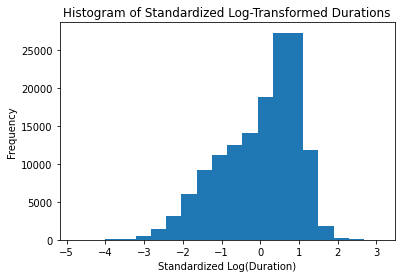

In [148]:
from sklearn.preprocessing import StandardScaler
# standardizing data (currently right-skewed)
durations_log_transformed = np.log(np.array(durations))

# Standardize the log-transformed data
scaler = StandardScaler()
durations_standardized = scaler.fit_transform(durations_log_transformed.reshape(-1, 1)).flatten()

# Plot the histogram of the standardized log-transformed data
plt.hist(durations_standardized, bins=20)
plt.title('Histogram of Standardized Log-Transformed Durations')
plt.xlabel('Standardized Log(Duration)')
plt.ylabel('Frequency')
plt.show()

In [149]:
noLength = pipeline(False,True,True,True,True,True,True)
print("Without length feature: ", noLength)

noQuestion = pipeline(True,False,True,True,True,True,True)
print("Without question feature: ", noQuestion)

noWords = pipeline(True,True,False,True,True,True,True)
print("Without words feature: ", noWords)

noSentence = pipeline(True,True,True,False,True,True,True)
print("Without sentence feature: ", noSentence)

noSpeaker = pipeline(True,True,True,True,False,True,True)
print("Without speaker feature: ", noSpeaker)

Without length feature:  [5.763735352202842, 333.6562424953815]
Without question feature:  [5.863267516924001, 467.9492883379847]
Without words feature:  [5.857632450028749, 488.6713465963127]
Without sentence feature:  [5.783914573586251, 358.4996547508553]
Without speaker feature:  [5.806721301058595, 410.8039977257006]


In [150]:
justLength = pipeline(True,False,False,False,False,True,True)
print("Length: ", justLength)

justSpeakerLength = pipeline(True,False,False,False,True,True,True)
print("Speaker and Length feature: ", justSpeakerLength)

justSpeakerLengthWords = pipeline(True,False,True,False,True,True,True)
print("Speaker, length, and Words Features: ", justSpeakerLengthWords)

SpeakerLengthWordsSentence = pipeline(True,False,True,True,True,True,True)
print("Speaker, length, words, Sentence Features: ", SpeakerLengthWordsSentence)

Length:  [6.0418234032679505, 497.1796186123482]
Speaker and Length feature:  [5.9766929945714145, 481.2309088877285]
Speaker, length, and Words Features:  [5.855694326991503, 415.6543957804724]
Speaker, length, words, Sentence Features:  [5.863267516924001, 467.9492883379847]


## Our model VS Speechify's base of 200 words per minute

In [151]:
def wpm(dataset):
    utterance_lengths = []
    word_counts = []
    durations = []
    predictions = []

    # Iterating through each episode
    for episode_id, turns in dataset.items():
        # Iterating through each turn in the episode
        for turn in turns:
            utterance_length = len(turn['utterance'])
            word_count = turn['n_words']
            duration = turn['utterance_end'] - turn['utterance_start']
            prediction = word_count / (200/60)
            
            utterance_lengths.append(utterance_length)
            word_counts.append(word_count)
            durations.append(duration) 
            predictions.append(prediction)
   
    return predictions

In [152]:
print(MAE(wpm(datasetTest), test_durations))

2.667946648563765


In [153]:
SpeakerLengthWordsSentence = pipeline(True,False,True,True,True)
print("Speaker, length, words, Sentence Features: ", SpeakerLengthWordsSentence)

Speaker, length, words, Sentence Features:  2.6725068790608604


#### Our linear regression model is almost as good as Speechify's 200wpm baseline model that it uses to predict the length of speeches users give to it.